<a href="https://colab.research.google.com/github/laura5186/Machine-Learning/blob/main/A8_AEs_and_VAEs_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 8: Autoencoders and Variational Autoencoders (Solution)

Autoencoders (AEs) are neural networks that aim to reconstruct their inputs by first compressing them into a lower-dimensional representation, and then decompressing them back to the original form. Variational Autoencoders (VAEs) are a type of generative model that extends AEs by introducing a probabilistic approach to the encoding process. You can learn more about AEs and VAEs from [Lilian Weng's blog](https://lilianweng.github.io/posts/2018-08-12-vae/) and Jeremy Jordan’s blog about understanding [Autoencoders](https://www.jeremyjordan.me/autoencoders/) and [Variational Autoencoders](https://www.jeremyjordan.me/variational-autoencoders/#:~:text=A%20variational%20autoencoder%20(VAE)%20providesdistribution%20for%20each%20latent%20attribute.).

First, let's install the necessary pip dependencies and download some necessary files

In [ ]:
!pip install torch==1.13.1 torchvision==0.14.1 pytorch-lightning==1.9.4 numpy==1.21.6 tqdm==4.65.0 matplotlib==3.5.3 tensorboard==2.11.2 --quiet
!wget https://raw.githubusercontent.com/tmvllrrl/Assignments/main/Autoencoders/dae.py
!wget https://raw.githubusercontent.com/tmvllrrl/Assignments/main/Autoencoders/vae.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 KB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Exercise 1: Denoising Autoencoders
---

In this exercise, we are going to create an encoder and decoder that will be used in a denoising autoencoder. Then, we will denoise some images.

- Use the following code to import the necessary packages and install any pip dependencies:
                        
        from dae import DenoisingAutoEncoder, train_dae, add_noise
        from vae import VariationalAutoEncoder, train_vae

        import os
        import random
        import numpy as np
        import matplotlib.pyplot as plt

        import torch
        from torch import nn
        import torch.nn.functional as F
        from torchvision import transforms
        from torchvision.datasets import MNIST, CIFAR10
        from torch.utils.data import DataLoader

        from pytorch_lightning import seed_everything
        seed_everything(42, workers=True) # Seeds random, numpy random, and pytorch, which is important for reproducibility

        to_img = transforms.ToPILImage() # Utility function that is used later in the lab


In [ ]:
from dae import DenoisingAutoEncoder, train_dae, add_noise
from vae import VariationalAutoEncoder, train_vae

import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader

from pytorch_lightning import seed_everything
seed_everything(42, workers=True) # Seeds random, numpy random, and pytorch, which is important for reproducibility

to_img = transforms.ToPILImage() # Utility function that is used later in the lab

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:lightning_fabric.utilities.seed:Global seed set to 42


- Next, let's load the dataset using the following code:

        cifar10_train = CIFAR10(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
        cifar10_train = torch.utils.data.Subset(cifar10_train, range(5000))

        cifar10_test = CIFAR10(os.getcwd(), train=False, download=True, transform=transforms.ToTensor())
        cifar10_test = torch.utils.data.Subset(cifar10_test, range(1000))

- Now, you are going to create 2 data loaders using `cifar10_train` and `cifar10_test` using the `Dataloader` class. The data loader for `cifar10_train` should be named `train_loader`, have a batch_size of `128`, shuffle should be `True`, and num_workers should be `2`. The data loader for `cifar10_test` should be the exact same except named `test_loader`.  

    Relevant Links:
    - [Dataloader API](https://pytorch.org/docs/stable/data.html)

In [ ]:
cifar10_train = CIFAR10(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
cifar10_train = torch.utils.data.Subset(cifar10_train, range(5000))

cifar10_test = CIFAR10(os.getcwd(), train=False, download=True, transform=transforms.ToTensor())
cifar10_test = torch.utils.data.Subset(cifar10_test, range(1000))

train_loader = DataLoader(cifar10_train, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_test, batch_size=128, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


- Use the following code to visualize the images from the CIFAR10 dataset and what they would look like with noise:

        fig, ax = plt.subplots(2,5,figsize = (12,6), dpi = 80)
        for i, batch in enumerate(train_loader):
            x, y = batch
            img = to_img(x[0])
            ax[0,i].imshow(img)
            
            noise_x = add_noise(x[0])
            noise_img = to_img(noise_x)
            ax[1, i].imshow(noise_img)
            
            if i==4:
                break

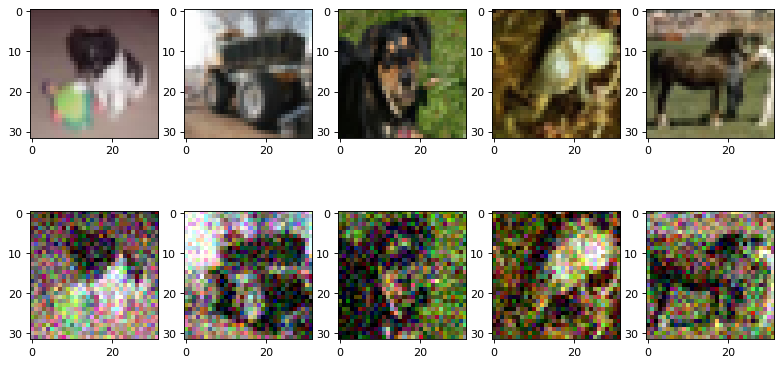

In [ ]:
fig, ax = plt.subplots(2,5,figsize = (12,6), dpi = 80)
for i, batch in enumerate(train_loader):
    x, y = batch
    img = to_img(x[0])
    ax[0,i].imshow(img)

    noise_x = add_noise(x[0])
    noise_img = to_img(noise_x)
    ax[1, i].imshow(noise_img)

    if i==4:
        break

- Next, we are going to finish the `Encoder` of the denoising autoencoder. Some boilerplate code has been provided for you. You are to fill in the rest of `self.encoder` following the sequence below (some of the layers have been done for you).

    The layers of the encoder are as follows (in order):
    1. A Conv2d layer with `3` in channels, `16` out channels, a kernel size of `3`, and padding of size `1`
    2. A ReLU activation layer
    3. A MaxPool2d layer with kernel size `2` with a stride of `2`
    4. A Conv2d layer with `16` in channels, `4` out channels, a kernel size of `3`, and padding of size `1`
    5. A ReLU activation layer
    6. A MaxPool2d layer with kernel size `2` with a stride of `2`

    Relevant Links:
    - [Sequential API](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)
    - [Conv2d API](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
    - [ReLU API](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
    - [MaxPool2d API](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,4,3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

    def forward(self, x):
        return self.encoder(x)

- Now you are going to finish out the `Decoder`. Complete `self.decoder` using the list of layers below:
    1. A ConvTranspose2d layer with `4` in channels, `16` out channels, and a stride of `2`
    2. A ReLU activation layer
    3. A ConvTranspose2d layer with `16` in channels, `3` out channels, and a stride of `2`
    4. A Sigmoid activation layer

    Relevant Links:
    - [ConvTranspose2D API](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d)
    - [Sigmoid API](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid)

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

- Now, let's train the denoising autoencoder! We make use of earlier imports and pass the created `Encoder` and `Decoder` classes to the model. The training should take around 5 minutes.

In [ ]:
dae = DenoisingAutoEncoder(Encoder(), Decoder())

# Utility function that trains the dae using the CIFAR10 data loader
train_dae(dae=dae, train_loader=train_loader)

/usr/local/lib/python3.9/dist-packages/lightning_fabric/accelerators/cuda.py:236: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 1.0 K 
1 | decoder | Decoder | 467   
------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/content/dae.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_x = torch.tensor(x) # Making a copy of x and labelling it noise_x



EPOCH TRAIN LOSS: 0.0666397362947464

EPOCH TRAIN LOSS: 0.061444561928510666

EPOCH TRAIN LOSS: 0.048529502004384995

EPOCH TRAIN LOSS: 0.03754112124443054

EPOCH TRAIN LOSS: 0.03244109824299812

EPOCH TRAIN LOSS: 0.029181892052292824

EPOCH TRAIN LOSS: 0.026287253946065903

EPOCH TRAIN LOSS: 0.023938769474625587

EPOCH TRAIN LOSS: 0.021958252415060997

EPOCH TRAIN LOSS: 0.019919421523809433

EPOCH TRAIN LOSS: 0.017592081800103188

EPOCH TRAIN LOSS: 0.01605311781167984

EPOCH TRAIN LOSS: 0.015395340509712696

EPOCH TRAIN LOSS: 0.01472744531929493

EPOCH TRAIN LOSS: 0.014268562197685242

EPOCH TRAIN LOSS: 0.01403038389980793

EPOCH TRAIN LOSS: 0.013776074163615704

EPOCH TRAIN LOSS: 0.013437749817967415

EPOCH TRAIN LOSS: 0.01312914676964283

EPOCH TRAIN LOSS: 0.01297435350716114

EPOCH TRAIN LOSS: 0.013041006401181221

EPOCH TRAIN LOSS: 0.012672634795308113

EPOCH TRAIN LOSS: 0.012603981420397758

EPOCH TRAIN LOSS: 0.01248261146247387

EPOCH TRAIN LOSS: 0.012437688186764717

EPOCH TRA

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.



EPOCH TRAIN LOSS: 0.011694824323058128


- Finally, use the following code to visualize denoising some noisy images:

        fig, ax = plt.subplots(3,5,figsize = (12,8), dpi = 80)
        for i, batch in enumerate(test_loader):
            x, y = batch
            img = to_img(x[0])
            ax[0,i].imshow(img)
            
            noise_x = add_noise(x[0])
            noise_img = to_img(noise_x)
            ax[1, i].imshow(noise_img)
            
            denoised_x = dae(x)
            denoised_img = to_img(denoised_x[0])
            ax[2, i].imshow(denoised_img)
            
            if i==4:
                break

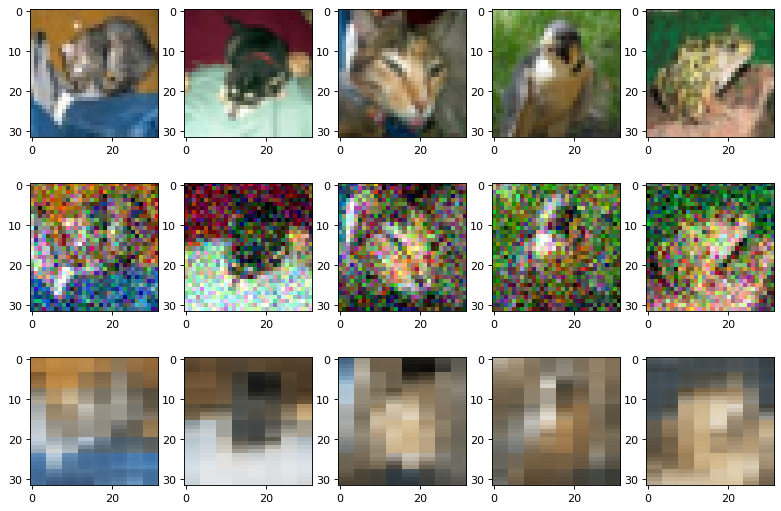

In [ ]:
fig, ax = plt.subplots(3,5,figsize = (12,8), dpi = 80)
for i, batch in enumerate(test_loader):
    x, y = batch
    img = to_img(x[0])
    ax[0,i].imshow(img)

    noise_x = add_noise(x[0])
    noise_img = to_img(noise_x)
    ax[1, i].imshow(noise_img)

    denoised_x = dae(x)
    denoised_img = to_img(denoised_x[0])
    ax[2, i].imshow(denoised_img)

    if i==4:
        break

### Exercise 2: VAEs (Variational Autoencoders)
---
In this exercise, we will train a variational autoencoder and create a fake number with it.

- First, let's load the MNIST dataset using the following code.

        # For this exercise, we are only concerned with the train split of MNIST
        mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transforms.toTensor())

- Define a data loader for `mnist_train` and store it in `mnist_loader`. The data loader should take in `mnist_train`, have a batch_size of `128`, shuffle should be `True`, and num_workers should be `2`.

    Relevant Links:
    - [Dataloader API](https://pytorch.org/docs/stable/data.html)

In [ ]:
# For this exercise, we are only concerned with the train split of MNIST
mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
mnist_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



- Use the following code to visualize the data:

        fig, ax = plt.subplots(1,5,figsize = (12,12), dpi = 80)
        for i, batch in enumerate(mnist_loader):
            x, y = batch
            img = to_img(x[0])
            ax[i].imshow(img, cmap='gray')
            
            if i==4:
                break

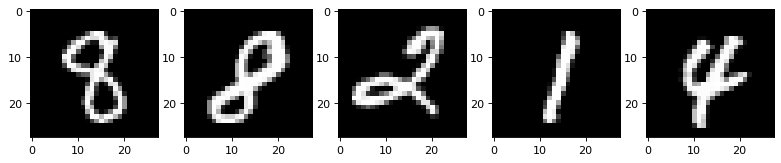

In [ ]:
fig, ax = plt.subplots(1,5,figsize = (12,12), dpi = 80)
for i, batch in enumerate(mnist_loader):
    x, y = batch
    img = to_img(x[0])
    ax[i].imshow(img, cmap='gray')

    if i==4:
        break

- In this next step, we are going to define the 2 linear layers for calculating the mean and standard deviation (NOTE: we actually calculate the variance with a linear layer, not the standard deviation. The variance can be turn into the standard deviation and is used for KL divergence). Create 2 variables, `self.mu` and `self.var` that are placed after `self.encoder`. They should both be linear layers with `16` in_channels and `2` out_channels

- Also, fill in the code in `forward()` where you are supposed to pass `x` through both `self.mu` and `self.var`.

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 16),
        )

        self.mu = nn.Linear(16, 2)
        self.var = nn.Linear(16, 2)


    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.encoder(x)

        mu = self.mu(x)
        var = self.var(x)

        # Reparameterization
        std = torch.exp(var / 2)
        eps = torch.randn_like(std)

        z = mu + std * eps

        return z, mu, var

# The Decoder class is taken care of for you
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x


- Now, we will train the variational autoencoder. This should take around 10 minutes.

In [ ]:
vae = VariationalAutoEncoder(Encoder(), Decoder())

# Utility function for training the vae. If you're curious, you can check out vae.py that gets downloaded to view some behind-the-scenes stuff!
train_vae(vae, mnist_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 102 K 
1 | decoder | Decoder | 103 K 
------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.824     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]


EPOCH TRAIN LOSS: 0.42383044958114624

EPOCH TRAIN LOSS: 0.2675134539604187

EPOCH TRAIN LOSS: 0.2645767629146576

EPOCH TRAIN LOSS: 0.26360955834388733

EPOCH TRAIN LOSS: 0.2633375823497772

EPOCH TRAIN LOSS: 0.26323744654655457

EPOCH TRAIN LOSS: 0.26320624351501465

EPOCH TRAIN LOSS: 0.2631680965423584

EPOCH TRAIN LOSS: 0.2631183862686157

EPOCH TRAIN LOSS: 0.2631233334541321

EPOCH TRAIN LOSS: 0.26310449838638306

EPOCH TRAIN LOSS: 0.26303306221961975

EPOCH TRAIN LOSS: 0.26305273175239563

EPOCH TRAIN LOSS: 0.26302510499954224

EPOCH TRAIN LOSS: 0.2629595994949341

EPOCH TRAIN LOSS: 0.26297155022621155

EPOCH TRAIN LOSS: 0.2629795968532562

EPOCH TRAIN LOSS: 0.26297080516815186

EPOCH TRAIN LOSS: 0.2629736363887787


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.



EPOCH TRAIN LOSS: 0.2629493474960327


- Use the following code to visualize and generate a fake image:

        # Sample a random vector, generate fake images and plot
        fig, ax = plt.subplots(1,1,figsize = (6,6), dpi = 80)
        for i, ax in enumerate(fig.axes):
        
            random_latent_vector = torch.rand(128, 2)
            print(random_latent_vector[0])
            fake_images = torch.moveaxis(vae(random_latent_vector), 1, -1).detach()

            ax.imshow(fake_images[0], cmap= 'gray')

tensor([0.2886, 0.9365])


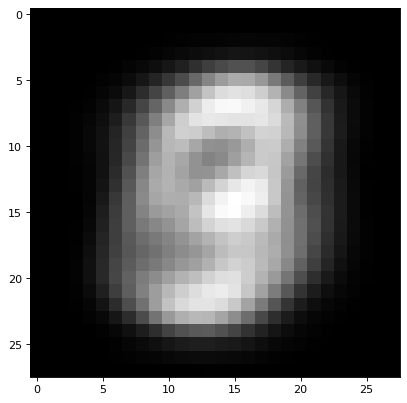

In [ ]:
# Sample a random vector, generate fake images and plot
fig, ax = plt.subplots(1,1,figsize = (6,6), dpi = 80)
for i, ax in enumerate(fig.axes):

    random_latent_vector = torch.rand(128, 2)
    print(random_latent_vector[0])
    fake_images = torch.moveaxis(vae(random_latent_vector), 1, -1).detach()

    ax.imshow(fake_images[0], cmap= 'gray')